# SETUP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
import io
import requests


/Users/alex/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/alex/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading Datasets

### Build the direct download URL from a file ID

In [2]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"
    
# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holidays_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

In [3]:
# Generalized loader function
def load_dataset(name):
    local_path = f"../data/{name}.csv"
    
    # 1. Try loading from local CSV
    if os.path.exists(local_path):
        try:
            df = pd.read_csv(local_path)
            print(f"✅ Loaded '{name}' from local CSV: {local_path}")
            return df
        except Exception as e:
            print(f"⚠️ Error loading local '{name}': {e}")

    # 2. Try loading from cloud (if available)
    if name in file_ids:
        try:
            url = make_drive_url(file_ids[name])
            df = load_csv_from_url(url)
            print(f"🌐 Loaded '{name}' from Google Drive")
            return df
        except Exception as e:
            print(f"⚠️ Failed to load '{name}' from cloud: {e}")
    else:
        print(f"❌ No file_id for dataset '{name}'")

    return None

# Function to load all datasets at once
def load_all_datasets(names):
    dataframes = {}
    for name in names:
        df = load_dataset(name)
        dataframes[name] = df
        if df is not None:
            print(f"   → {name}: shape {df.shape}")
        else:
            print(f"   → {name}: not loaded")
    return dataframes


# Define needed datasets (you can easily add/remove names here)
dataset_names = [
    "holidays_events", "items", "oil", "stores", "train"
]

# Load all data
dfs = load_all_datasets(dataset_names)

✅ Loaded 'holidays_events' from local CSV: ../data/holidays_events.csv
   → holidays_events: shape (350, 6)
✅ Loaded 'items' from local CSV: ../data/items.csv
   → items: shape (4100, 4)
✅ Loaded 'oil' from local CSV: ../data/oil.csv
   → oil: shape (1218, 2)
✅ Loaded 'stores' from local CSV: ../data/stores.csv
   → stores: shape (54, 5)


/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/888018156.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


✅ Loaded 'train' from local CSV: ../data/train.csv
   → train: shape (125497040, 6)


### **1. Stores Data**


- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [4]:
# Load the 'stores' DataFrame from the previously loaded datasets and display its head
df_stores = dfs["stores"]
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


- Filter store IDs located in the 'Guayas' state

In [5]:
# Extract unique store numbers for stores where the state is 'Guayas'
filtered_store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
df_stores = df_stores[df_stores["store_nbr"].isin(filtered_store_ids)]

### **2. Holidays Events Data**


**NOTE:** 
- Pay special attention to the `transferred` column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 
- Days that are type `Bridge` are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- `Additional` holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [6]:
# Load the 'holidays_events' DataFrame from the previously loaded datasets and display its head
df_holidays_events = dfs["holidays_events"]
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### **3. Items Data**

In [7]:
# Load the 'items' DataFrame from the previously loaded datasets and display its head
df_items = dfs["items"]
df_items['perishable'].value_counts()

perishable
0    3114
1     986
Name: count, dtype: int64

In [8]:
df_items['family'].value_counts().head(5)

family
GROCERY I    1334
BEVERAGES     613
CLEANING      446
PRODUCE       306
DAIRY         242
Name: count, dtype: int64

- Identify top 3 product families and their corresponding item IDs for feature filtering

In [9]:
# Count how many items belong to each family
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['family', 'count']

# Select the top 3 families with the highest number of items
top_3_family = items_per_family.head(3)['family']

# Get all unique item IDs that belong to these top 3 families
item_ids_top_3_family = df_items[df_items['family'].isin(top_3_family)]['item_nbr'].unique()

### **4. Oil Data**


- Includes values during both the train and test data timeframe. Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [10]:
# Load the 'oil' DataFrame from the previously loaded datasets and display its head
df_oil = dfs["oil"]
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


### **7. Train Data**




#### Data Infos:

- Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
- The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
- Negative values of unit_sales represent returns of that particular item.
- The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
- Approximately 16% of the onpromotion values in this file are NaN.

**NOTE:** The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

-  `Load and filter large CSV files in chunks` (locally or from Google Drive)

In [11]:

def load_data_with_chunks(dataset_name, local_paths, chunk_size=10**6, filter_store_ids=None, filter_item_ids=None):
    """
    Loads and filters large datasets in chunks, either from local storage or Google Drive.
    
    Args:
        dataset_name (str): Name of the dataset (must exist in file_ids).
        local_paths (list): Paths to local CSV files.
        chunk_size (int, optional): Rows per chunk (default: 1,000,000).
        filter_store_ids (list, optional): List of store_nbrs to filter by.
        filter_item_ids (list/array, optional): List of item_nbrs to filter by.
    
    Returns:
        pd.DataFrame: Combined filtered data, or None if loading failed.
    """

    # --- Helper function to filter each chunk ---
    def filter_chunk(chunk):
        if filter_store_ids is not None:
            chunk = chunk[chunk['store_nbr'].isin(filter_store_ids)]
        if filter_item_ids is not None:
            chunk = chunk[chunk['item_nbr'].isin(filter_item_ids)]
        return chunk

    # --- 1. Try loading from local file(s) ---
    for path in local_paths:
        if os.path.exists(path):
            try:
                filtered_chunks = []
                for chunk in pd.read_csv(path, chunksize=chunk_size):
                    chunk = filter_chunk(chunk)
                    if not chunk.empty:
                        filtered_chunks.append(chunk)
                if filtered_chunks:
                    df = pd.concat(filtered_chunks, ignore_index=True)
                    print(f"✅ Successfully loaded local data (chunked): {path}")
                    return df
                else:
                    print(f"⚠️ No rows matched filters in {path}")
                    return pd.DataFrame()
            except Exception as e:
                print(f"❌ Error loading {path}: {e}")

    # --- 2. Try loading from Google Drive using file_ids ---
    if dataset_name in file_ids:
        try:
            url = make_drive_url(file_ids[dataset_name])
            response = requests.get(url)
            response.raise_for_status()
            
            filtered_chunks = []
            for chunk in pd.read_csv(io.StringIO(response.text), chunksize=chunk_size):
                chunk = filter_chunk(chunk)
                if not chunk.empty:
                    filtered_chunks.append(chunk)
            
            if filtered_chunks:
                df = pd.concat(filtered_chunks, ignore_index=True)
                print(f"🌐 Successfully loaded '{dataset_name}' from Google Drive (chunked)")
                return df
            else:
                print(f"⚠️ No rows matched filters in Google Drive data for '{dataset_name}'")
                return pd.DataFrame()
        except Exception as e:
            print(f"❌ Failed to load '{dataset_name}' from Google Drive: {e}")
    else:
        print(f"🚫 No file ID found for dataset '{dataset_name}'")

    print("🚫 No data source was available")
    return None


# --- Load filtered training data ---
df_train = load_data_with_chunks(
    dataset_name='train',
    local_paths=['../data/train.csv'],
    filter_store_ids=filtered_store_ids,
    filter_item_ids=item_ids_top_3_family
)

# --- Preliminary data analysis ---
print(f"Dataset size: {df_train.shape}")
df_train.head()

/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/3245500694.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, chunksize=chunk_size):


✅ Successfully loaded local data (chunked): ../data/train.csv
Dataset size: (14745768, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18790,2013-01-02,24,105574,12.0,NaN
1,18791,2013-01-02,24,105575,2.0,NaN
2,18792,2013-01-02,24,105577,1.0,NaN
3,18793,2013-01-02,24,105693,7.0,NaN
4,18794,2013-01-02,24,105737,17.0,NaN


In [12]:
df_train['date'].min(), df_train['date'].max()

('2013-01-02', '2017-08-15')

# EDA 

## df_stores

### 1. Missing Value Analysis
- No missing Values

In [13]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### 2. Data Quality Checks

#### a. Store Numbers:
✅ All store numbers are unique (11 unique values)

✅ Sequential from 24 to 51 with no gaps

In [14]:
print(f"Unique stores: {df_stores['store_nbr'].nunique()} "
      f"out of {len(df_stores)}")

print(f"Store number range: {df_stores['store_nbr'].min()} "
      f"to {df_stores['store_nbr'].max()}")

Unique stores: 11 out of 11
Store number range: 24 to 51


#### b. Store Type Validation:
- Types: A(8), B(9), C(15), D(17), E(5)

- No missing or unexpected types

In [15]:
print(df_stores['type'].value_counts())

type
D    3
E    3
C    3
B    1
A    1
Name: count, dtype: int64


#### c. Cluster Analysis:

- 17 unique clusters (1-17)

- Some clusters have only 1 store (e.g., 5,12,16,17)

- Cluster 3 appears most frequently (7 stores)

In [16]:
print(f"Unique clusters: {df_stores['cluster'].nunique()}")
print(df_stores['cluster'].value_counts())

Unique clusters: 5
cluster
10    4
3     3
1     2
6     1
17    1
Name: count, dtype: int64


## df_holidays_events

### 1. Checking for Missing Data
- No missing Values

In [17]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [63]:
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print(f"{df_holidays_events['date'].min()} -> {df_holidays_events['date'].max()}")

2012-03-02 00:00:00 -> 2017-12-26 00:00:00


### 2. Data Consistency Validation

-  Event Types (type)

In [18]:
print(df_holidays_events['type'].value_counts())

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64


- Geographic Scope (locale)

In [19]:
print(df_holidays_events['locale'].value_counts())

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64


- Date Validation:
  - 'date' datatype - object => pd.to_datetime()

In [20]:
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print(
    "Holiday file covers:",
    df_holidays_events['date'].dt.date.min(), "→",
    df_holidays_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


## df_items

### 1. Checking for Missing Data
- No missing Values

In [21]:
# Checking missing values
df_items.isnull().sum()

item_nbr      0
family        0
class         0
perishable    0
dtype: int64

## df_oil

In [22]:
df_oil['date'] = pd.to_datetime(df_oil['date'])
print(df_oil['date'].dt.year.value_counts().sort_index())

date
2013    261
2014    261
2015    261
2016    261
2017    174
Name: count, dtype: int64


### 3. Data Quality Checks:

#### a. Date Continuity Check:
- ✅ No missing *business/trading days* (Monday-Friday)
- ⚠️ Expected missing *weekends/holidays* (2013-01-01 to 2017-08-31 = ~4.66 years × 104 weekend days/year ≈ 486 days)
- All calendar dates present in the index, but prices only exist for trading days

In [23]:
date_range = pd.date_range(start=df_oil['date'].min(), end=df_oil['date'].max())
missing_dates = date_range[~date_range.isin(df_oil['date'])]
print(f"Missing dates in sequence: {len(missing_dates)}")


Missing dates in sequence: 486


In [24]:
# Create DataFrame for missing dates with weekday information
df_missing_dates = pd.DataFrame({
    'date': missing_dates,
    'weekday': missing_dates.day_name()
})
df_missing_dates['weekday'].value_counts()

weekday
Saturday    243
Sunday      243
Name: count, dtype: int64

#### b. Value Range Validation:
- Valid range: $26.19 - $110.62

## df_train 

### 1. Date Validation:
- 'date' datatype - object => pd.to_datetime()

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14745768 entries, 0 to 14745767
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 675.0+ MB


In [26]:
df_train['date'] = pd.to_datetime(df_train['date'])
print(df_train['date'].dt.year.value_counts().sort_index())

date
2013    2118130
2014    2557016
2015    3339331
2016    4050506
2017    2680785
Name: count, dtype: int64


In [27]:
print(f'{df_train["date"].min()} -> {df_train["date"].max()}')

2013-01-02 00:00:00 -> 2017-08-15 00:00:00


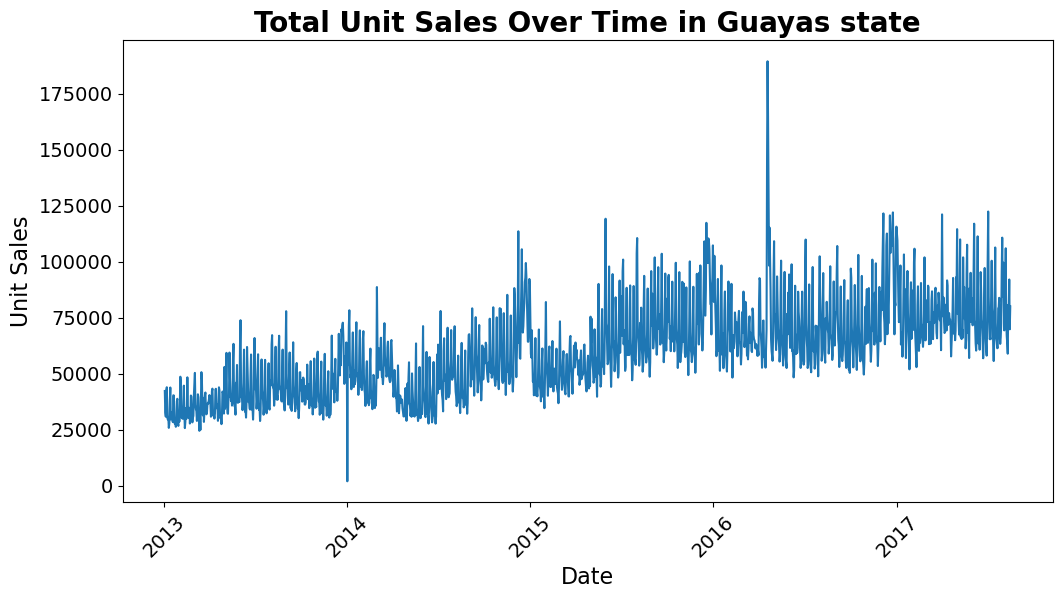

In [28]:
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

### 2. Missing Value Analysis
- 2747275 missing Value in the 'onpromotion' column (18.63% of total data) => .fillna(False/True)

In [29]:
# Checking missing values
missing_values = df_train.isnull().sum()
print(f"Missing values:\n{missing_values}")
print(f"\nTotal records: {len(df_train)}")
print(f"Missing percentage: {missing_values['onpromotion']/len(df_train)*100:.2f}%")

Missing values:
id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

Total records: 14745768
Missing percentage: 18.63%


In [30]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].astype(str)
df_train['onpromotion'].value_counts()

onpromotion
False    11319196
nan       2747275
True       679297
Name: count, dtype: int64

#### Function: Temporal Promotion Gap Filling FOR Fill Missing Dates with Zero Sales



##### Purpose of the Function

- Gap Filling: Avoids NaN values through logical interpolation (forward/backward in time).

- Data Quality: Sets a default value (False) if no promotion information is available.

##### Example Input/Output:

- Before: ['True', '0', nan, 'False']

- After: [True, nan, nan, False] → [True, True, False, False] (after ffill/bfill).

In [31]:


def fill_onpromotion_gaps(group):
    # Sicherstellen, dass die Gruppe nach Datum sortiert ist
    group = group.sort_values('date').reset_index(drop=True)
    
    # Konvertiere 'False'/'True' in Bool, 'nan' in np.nan
    group['onpromotion'] = (
        group['onpromotion']
        .replace({'False': False, 'True': True, 'nan': np.nan})
        .where(group['onpromotion'] != 'nan', np.nan)
    )
    
    # Finde alle NaN-Werte (echte Lücken)
    nan_mask = group['onpromotion'].isna()
    
    # Wenn keine Lücken, direkt zurückgeben (als String)
    if not nan_mask.any():
        group['onpromotion'] = group['onpromotion'].astype(str)
        return group
    
    # Fülle Lücken mit intelligenter Logik:
    # 1. Forward Fill (letzter bekannter Wert)
    # 2. Backward Fill (nächster bekannter Wert)
    # 3. Falls keine Nachbarwerte: Default 'False'
    group['onpromotion'] = (
        group['onpromotion']
        .ffill()  # Vorwärts auffüllen
        .bfill()  # Rückwärts auffüllen
        .fillna(False)  # Falls keine Werte vorhanden: Default False
    )
    
    # Zurück zu String-Format
    group['onpromotion'] = group['onpromotion'].map({False: 'False', True: 'True'})
    
    return group

# Anwendung
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values(['item_nbr', 'date'])
df_train = df_train.groupby('item_nbr', group_keys=False).apply(fill_onpromotion_gaps)

# Überprüfung
print(df_train['onpromotion'].value_counts(dropna=False))

/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/198580145.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group['onpromotion']
/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/198580145.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group['onpromotion']
/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/198580145.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. 

onpromotion
False    14064341
True       681427
Name: count, dtype: int64


/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/198580145.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('item_nbr', group_keys=False).apply(fill_onpromotion_gaps)


#### Promotion Pattern Analysis FOR Fill Missing Dates with Zero Sales
**Purpose:**
Analyzes promotion patterns (onpromotion) for each product (item_nbr) to quantify how frequently items are promoted and identify trends.

In [32]:
# Group by item_nbr and analyze the onpromotion column (string type)
promo_analysis = df_train.groupby('item_nbr')['onpromotion'].agg([
    ('total_records', 'count'),  # Total records per item
    ('promo_records', lambda x: sum(x == 'True')),  # Count of 'True' promotions
    ('non_promo_records', lambda x: sum(x == 'False')),  # Count of 'False'
    ('promo_percentage', lambda x: f"{round(sum(x == 'True')/len(x)*100, 1)}%"),  # Promotion rate
    ('promo_pattern', lambda x: tuple(1 if v == 'True' else 0 for v in x))  # Binary pattern
]).reset_index()

# Calculate additional metrics
promo_analysis['promo_ratio'] = promo_analysis['promo_records'] / promo_analysis['total_records']
promo_analysis['has_promo'] = promo_analysis['promo_records'] > 0


# Sort by promotion count (descending) and display top 10
promo_analysis = promo_analysis.sort_values('promo_records', ascending=False)
print(promo_analysis.head(10))


      item_nbr  total_records  promo_records  non_promo_records  \
268     323013          15926           3078              12848   
1152   1157329          15064           2511              12553   
172     261052          16257           2428              13829   
731     848765          16952           2362              14590   
1568   1463808          10206           2324               7882   
1503   1459058           8366           2297               6069   
1122   1146786          15409           2281              13128   
1667   1464218          10357           2254               8103   
1181   1162382          14990           2119              12871   
1569   1463810           8669           2056               6613   

     promo_percentage                                      promo_pattern  \
268             19.3%  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1152            16.7%  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
172             14.9%  (0, 0, 0, 0

### 3. Handling Outliers:
- Negative spikes that represent product returns
- One-day sales explosions (promo errors, data glitches) that can pull the model off-course.

#### Product returns:

In [35]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
746,7152458,2013-06-18,51,103520,-1.0,False
7134,115403262,2017-05-12,30,103520,-1.0,False
1527,18912734,2014-02-13,51,105575,-1.0,False
1642,39186431,2015-01-11,51,105577,-1.0,False
3788,84016108,2016-07-04,27,105737,-13.0,False


In [36]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))
# Checking negative sales got correctly replaced
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


#### Extremely high sales:

In [37]:
# Berechnung der Z-Scores mit transform (vektorisiert)
grouped = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
mean_sales = grouped.transform('mean')
std_sales = grouped.transform('std')

# Vermeide Division durch Null (ersetze std=0 durch 1)
std_sales = std_sales.replace(0, 1)

# Z-Score berechnen
df_train['z_score'] = (df_train['unit_sales'] - mean_sales) / std_sales

# Outlier identifizieren
outliers = df_train[df_train['z_score'] > 5]
print(f"Anzahl der Outlier: {len(outliers)}")
outliers.head()

Anzahl der Outlier: 48485


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
694,15666702,2013-12-18,24,96995,14.0,False,7.946399
727,16251733,2013-12-30,36,96995,11.0,False,6.177341
735,16297258,2013-12-31,28,96995,12.0,False,5.760499
736,16303593,2013-12-31,36,96995,14.0,False,8.143725
816,27504850,2014-07-19,51,96995,13.0,False,7.763654


In [39]:
'''# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]
outliers'''

"# Function to calculate Z-score for each group (store-item combination)\ndef calculate_store_item_zscore(group):\n    # Compute mean and standard deviation for each store-item group\n    mean_sales = group['unit_sales'].mean()\n    std_sales = group['unit_sales'].std()\n\n    # Calculate Z-score (avoiding division by zero for standard deviation)\n    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)\n    return group\n\ndf_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)\ndf_train_grouped.reset_index(drop=True, inplace=True)\n\n# Define threshold for outliers (e.g., Z-score > 5)\noutliers = df_train_grouped[df_train_grouped['z_score'] > 5]\noutliers"

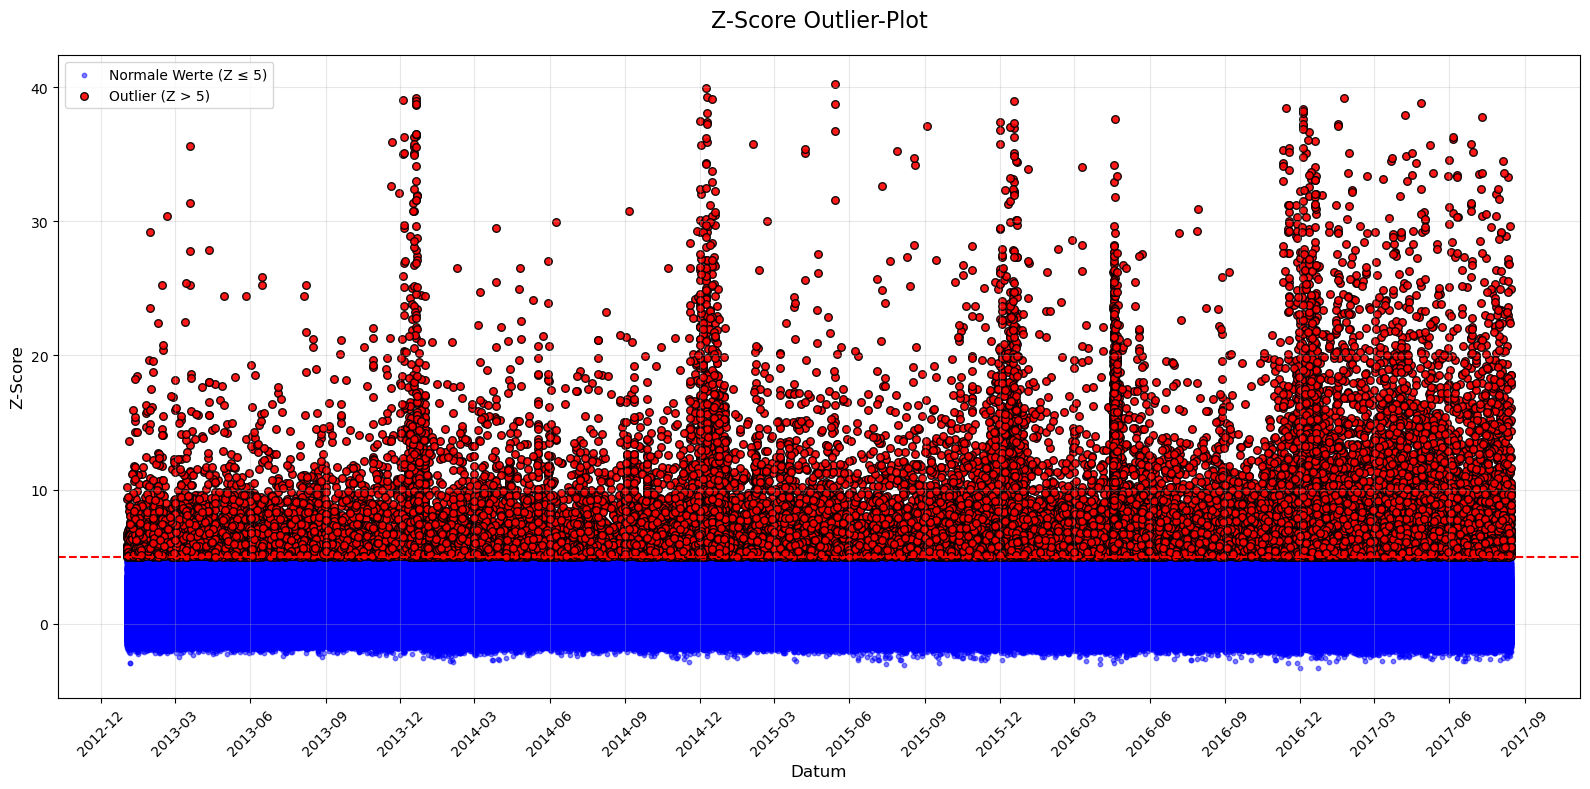

In [41]:
import matplotlib.dates as mdates

# Outlier- und Normal-Daten trennen
df_out = df_train[df_train['z_score'] > 5]
df_norm = df_train[df_train['z_score'] <= 5]

plt.figure(figsize=(16, 8))

# ► Normale Werte (unter 5)
plt.scatter(
    df_norm['date'],
    df_norm['z_score'],
    s=10,
    alpha=0.5,
    color='blue',
    label='Normale Werte (Z ≤ 5)'
)

# ► Outlier (über 5)
plt.scatter(
    df_out['date'],
    df_out['z_score'],
    s=30,
    alpha=0.9,
    color='red',
    edgecolor='black',
    label='Outlier (Z > 5)'
)

# Threshold-Linie
plt.axhline(5, linestyle='--', color='red', linewidth=1.5)

# Titel und Achsen
plt.title("Z-Score Outlier-Plot", fontsize=16, pad=20)
plt.xlabel("Datum", fontsize=12)
plt.ylabel("Z-Score", fontsize=12)
plt.grid(alpha=0.3)

# X-Achse Format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

### To avoid unnecessary gaps in the data, outliers are replaced with a rolling mean of the last 7 days

In [42]:
# Outlier-Bereinigung mit Rolling Median pro Store/Item

# Rolling median pro Store/Item berechnen
df_train['rolling_median'] = (
    df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
            .transform(lambda x: x.rolling(window=7, center=True, min_periods=1).median())
)

# Outlier ersetzen
df_train.loc[outliers.index, 'unit_sales'] = df_train.loc[outliers.index, 'rolling_median']

# Temporäre Hilfsspalte löschen
df_train.drop(columns=['rolling_median'], inplace=True)

# 2️⃣ Z-Score NEU berechnen und alte Spalte überschreiben
grouped_clean = df_train.groupby(['store_nbr', 'item_nbr'])
df_train['z_score'] = (
    (df_train['unit_sales'] - grouped_clean['unit_sales'].transform('mean'))
    / grouped_clean['unit_sales'].transform('std').replace(0, 1)
)

### 4. Fill missing dates with zero sales
**Goal:** every product in every store has one row per calendar day. If nothing sold, unit_sales should be 0.

In [43]:
df_train[df_train['unit_sales'] > 0]  # Verify no negative sales remain

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
0,302230,2013-01-09,24,96995,2.0,False,0.545503
1,361049,2013-01-10,51,96995,1.0,False,-0.500039
2,381401,2013-01-11,26,96995,1.0,False,-0.125988
3,400276,2013-01-11,51,96995,1.0,False,-0.500039
4,419989,2013-01-12,24,96995,2.0,False,0.545503
...,...,...,...,...,...,...,...
31,125130424,2017-08-12,27,2127114,2.5,False,0.110750
32,125230202,2017-08-13,24,2127114,2.5,False,2.666667
33,125235630,2017-08-13,27,2127114,3.0,False,0.775248
34,125341058,2017-08-14,27,2127114,3.5,False,1.439747


In [44]:

# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

df_train = df_filled
del df_filled

In [45]:
df_train.drop(['id'], axis=1, inplace=True)

In [46]:
df_train.isna().sum()

store_nbr             0
item_nbr              0
date                  0
unit_sales            0
onpromotion    20323588
z_score        20323673
dtype: int64

In [47]:
df_train['z_score'].fillna(0, inplace=True)

/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/3585996661.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['z_score'].fillna(0, inplace=True)


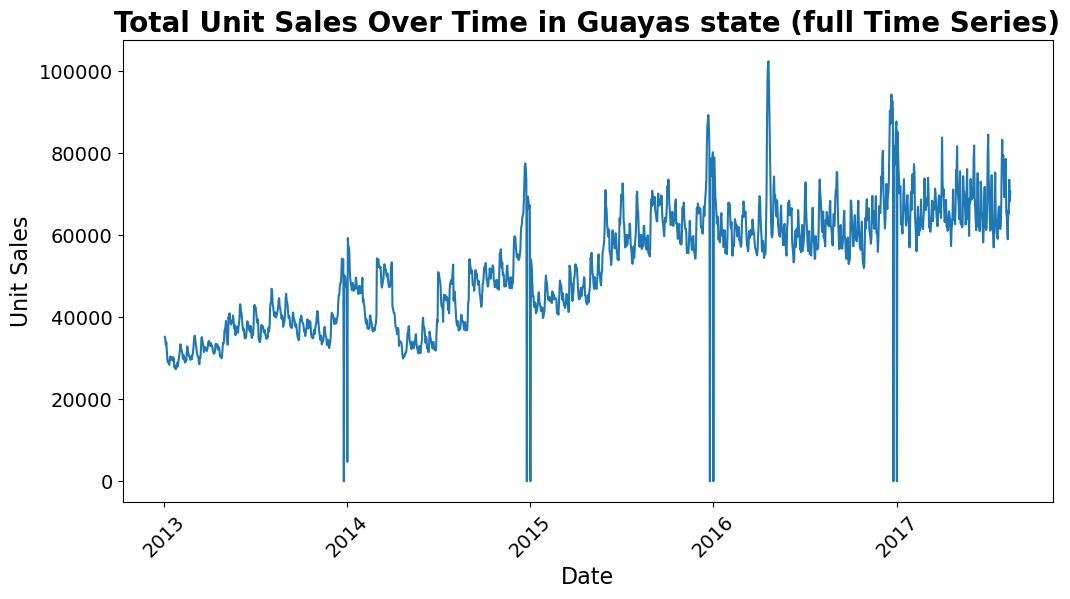

In [48]:
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state (full Time Series)', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [51]:
df_train.shape

(35069356, 6)

#### Handling Null Values in 'onpromotion' AFTER Fill Missing Dates with Zero Sales

#### **Function: Temporal Promotion Gap Filling**


In [52]:
df_train['onpromotion'].astype(str)

0             nan
1             nan
2             nan
3             nan
4             nan
            ...  
35069351      nan
35069352      nan
35069353      nan
35069354      nan
35069355    False
Name: onpromotion, Length: 35069356, dtype: object

In [53]:
df_train['onpromotion'].value_counts()

onpromotion
False    14064341
True       681427
Name: count, dtype: int64

In [54]:
def fill_onpromotion_gaps(group):
    # 1. Sort by date
    group = group.sort_values('date')
    
    # 2. Convert to consistent format
    # First handle string representations
    if group['onpromotion'].dtype == object:
        group['onpromotion'] = (
            group['onpromotion']
            .astype(str)
            .str.lower()
            .replace({
                'false': False,
                'true': True,
                'nan': np.nan,
                '0': np.nan,
                '1': True,
                '': np.nan
            })
        )
    # Then convert numeric/other types
    group['onpromotion'] = (
        group['onpromotion']
        .replace({
            0: False,
            1: True,
            '0': False,
            '1': True
        })
        .astype('boolean')  # Uses pandas' nullable boolean type
    )
    
    # 3. Fill gaps
    group['onpromotion'] = (
        group['onpromotion']
        .ffill()
        .bfill()
        .fillna(False)  # Default for remaining gaps
    )
    
    return group

# Application with error handling
try:
    df_train = (
        df_train.sort_values(['item_nbr', 'date'])
        .groupby('item_nbr', group_keys=False)
        .apply(fill_onpromotion_gaps)
    )
    
    # Verification
    print("Value counts after processing:")
    print(df_train['onpromotion'].value_counts())
    
except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("Problematic values in 'onpromotion':")
    print(df_train['onpromotion'].unique())

Value counts after processing:
onpromotion
False    33837116
True      1232240
Name: count, dtype: Int64


/var/folders/dj/qfwf7yns3z51j2jzcghy6r980000gn/T/ipykernel_2120/25445597.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train.sort_values(['item_nbr', 'date'])


In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35069356 entries, 0 to 35069355
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    int64         
 1   item_nbr     int64         
 2   date         datetime64[ns]
 3   unit_sales   float64       
 4   onpromotion  boolean       
 5   z_score      float64       
dtypes: boolean(1), datetime64[ns](1), float64(2), int64(2)
memory usage: 1.6 GB


#### Promotion Pattern Analysis AFTER Fill Missing Dates with Zero Sales
**Purpose:**
Analyzes promotion patterns (onpromotion) for each product (item_nbr) to quantify how frequently items are promoted and identify trends.

In [56]:
# Group by item_nbr and analyze the onpromotion column (string type)
promo_analysis = df_train.groupby('item_nbr')['onpromotion'].agg([
    ('total_records', 'count'),  # Total records per item
    ('promo_records', lambda x: sum(x == True)),  # Count of 'True' promotions
    ('non_promo_records', lambda x: sum(x == False)),  # Count of 'False'
    ('promo_percentage', lambda x: f"{round(sum(x == True)/len(x)*100, 1)}%"),  # Promotion rate
    ('promo_pattern', lambda x: tuple(1 if v == True else 0 for v in x))  # Binary pattern
]).reset_index()

# Calculate additional metrics
promo_analysis['promo_ratio'] = promo_analysis['promo_records'] / promo_analysis['total_records']
promo_analysis['has_promo'] = promo_analysis['promo_records'] > 0


# Sort by promotion count (descending) and display top 10
promo_analysis = promo_analysis.sort_values('promo_records', ascending=False)
print(promo_analysis.head(10))

      item_nbr  total_records  promo_records  non_promo_records  \
2228   2048362          18557          16342               2215   
2216   2048163          18557          16268               2289   
2221   2048246          18557          16110               2447   
2169   2028696          18557          16085               2472   
2238   2048609          18557          15801               2756   
2112   2014094          18557          15336               3221   
2108   2013931          18557          15152               3405   
1890   1973606          18557          14237               4320   
2109   2014053          16870          13958               2912   
2166   2028217          13496          11715               1781   

     promo_percentage                                      promo_pattern  \
2228            88.1%  (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2216            87.7%  (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2221            86.8%  (1, 1, 1, 1

### 5. Feature Engineering:

#### a. Year, Month, Day, and Day of Week 

In [57]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Split the timestamp into model-friendly parts
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['weekday'] = df_train['date'].dt.weekday # Monday=0 … Sunday=6



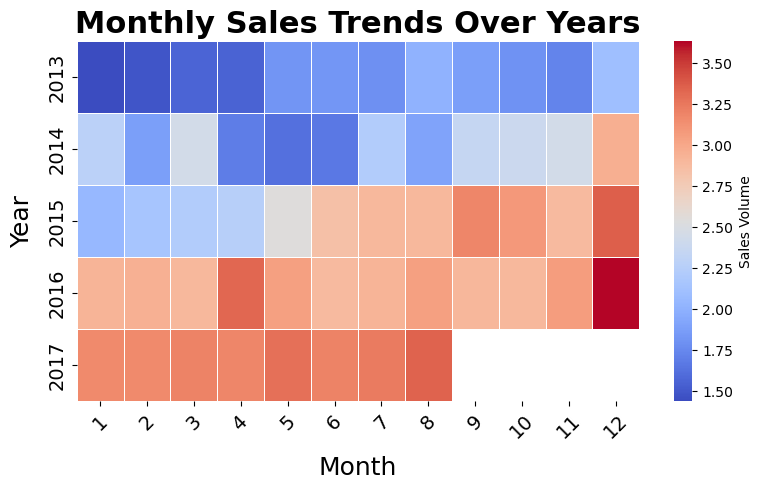

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Daten aggregieren ---
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].mean().unstack()
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month, 
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()


In [59]:
df_train['onpromotion'] = df_train['onpromotion'].map({False: 0, True: 1})  # Convert boolean to numeric

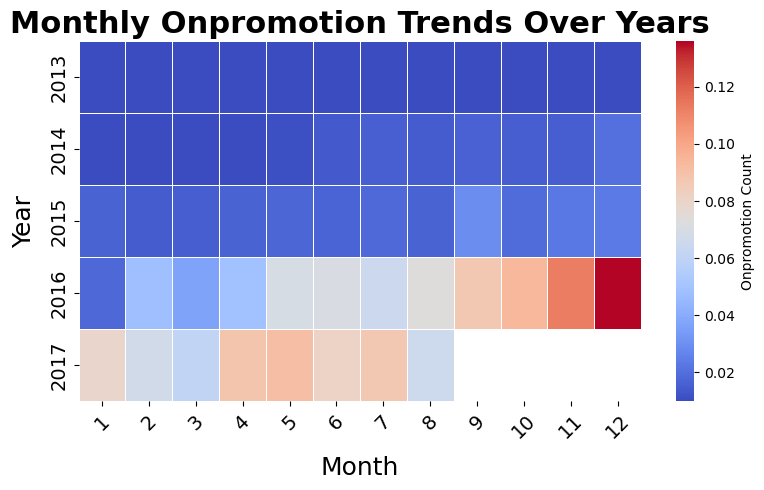

In [60]:
# --- Daten aggregieren ---

onpromotion_by_month = df_train.groupby(['year', 'month'])['onpromotion'].mean().unstack()
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    onpromotion_by_month, 
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Onpromotion Count'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Onpromotion Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

# Save the preprosessed Data

In [61]:
df_train.to_csv('../data/train__preprozessed.csv', index=False, sep=';')